In [1]:
import numpy as np
import csv

In [2]:
labels = []

with open("images/faceLabels.csv") as csvfile:
    reader = csv.reader(csvfile, delimiter=",")
    for row in reader:
        labels.append(row)
labels = np.array(labels[1:])
len(labels)

1999

In [3]:
from skimage import color
from skimage import io
from skimage.transform import resize
import matplotlib.pyplot as plt
from tqdm import tqdm

In [4]:
#if true, re-reads and saves all images to numpy array
if False:
    images = []
    size = (128,128)
    print("reading in images...")
    for line in tqdm(labels):
        ##read and convert to Black and White

        img = io.imread('images/'+line[0], as_grey=True)
        img = resize(img, size)
        images.append(img)
    print("saving...")
    
    npimages = np.zeros(shape=(len(images),*size), dtype=np.float64)
    for i,im in enumerate(images):
        npimages[i] = im
    labels = np.array(labels[:,1],dtype=str)
    print(labels)
    np.save("data/labels.npy",labels)
    np.save("data/images.npy",npimages)
    print("SAVED")
    

In [5]:
images = np.load("data/images.npy")
labels = np.load("data/labels.npy")
print(images.dtype)
print(labels.dtype)

float64
<U12


		Sad


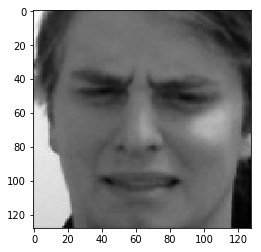

In [6]:
idx = np.random.randint(0,len(labels))
plt.imshow(images[idx], cmap="gray")
print("\t\t"+str(labels[idx]))

In [7]:
import random
def balanced_subset(images,labels):
    #np.warnings.filterwarnings('ignore')
    count = Counter(labels)
    perclass_count = np.array([[c,count[c]] for c in count.keys()])
    max_n = min(perclass_count[:,1])
    
    perclass_indexes = {cname:random.sample(range(0, n), max_n) for cname,n in perclass_count}
    perclass_index = {label:0 for label in count.keys()}
    
    newlabels = []
    newimages = []
    total = 0
    for i in range(len(labels)):
        
        label = labels[i]

        if perclass_index[label] in perclass_indexes[label]:
            total += 1
            newlabels.append(label)
            newimages.append(images[i])
        perclass_index[label] += 1
            
    newimages, newlabels = np.array(newimages),np.array(newlabels)   
        
    #print(perclass_count,perclass_indexes)
    return newimages, newlabels

In [8]:
from collections import Counter
labels = [x.lower() for x in labels]
count = Counter(labels)
#print(c.most_common())
label2int = {y:x for x,(y,_) in enumerate(count.most_common())}
int2label = {label2int[key]:key for key in label2int.keys()}

nplabels = np.array([label2int[x] for x in labels])
assert(len(nplabels) == len(images))
print("count:",count.most_common(),"\n")

count: [('happy', 500), ('sad', 500), ('angry', 500), ('neutral', 499)] 



In [9]:
def one_hot(labels):
    y = np.zeros([len(labels),max(labels)+1],dtype=int)
    y[np.arange(len(labels)),labels] = 1
    return y

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
x_train, x_val, y_train, y_val = train_test_split(images, nplabels, test_size=.1)
y_train = one_hot(y_train)
y_val = one_hot(y_val)
len(y_val)


200

In [11]:
def next_batch(images, labels, batch_size):
    images, labels = shuffle(images,labels)
    zeros = np.zeros([len(labels),max(labels)+1],dtype=int)
    zeros[np.arange(len(labels)),labels] = 1
    onehotLabels =  zeros
    for i in range(0,len(onehotLabels),batch_size):
        if i+batch_size >= len(onehotLabels):
            yield images[i:],onehotLabels[i:]
        else:
            yield images[i:i+batch_size],onehotLabels[i:i+batch_size]

In [12]:
print(images[0].shape)

(128, 128)


# Build Model

In [13]:
import tensorflow as tf
from Expression_Network import Expression_Network

Limited tf.compat.v2.summary API due to missing TensorBoard installation
Limited tf.summary API due to missing TensorBoard installation


In [14]:
num_classes = len(count.most_common())
#x = tf.placeholder(dtype=tf.float32, shape=(None,128,128),name='x')
#y = tf.placeholder(dtype=tf.int32, shape=(None),name="y")
#lr = tf.placeholder(dtype=tf.float32, shape=[], name="lr")
#one_hot = tf.one_hot(y,num_classes)
#reshaped = tf.expand_dims(x,-1)

exnet = Expression_Network(num_classes,Training=True).build_model()
exnet.build(input_shape=(None,128,128))
exnet.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 128, 128, 1)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 120, 120, 32)      2624      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 30, 30, 32)        0         
_________________________________________________________________
batch_normalization_v2 (Batc (None, 30, 30, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 20, 20, 64)        247872    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
dropout (Dropout)            (None, 5, 5, 64)          0

In [15]:
exnet.compile("Adam","categorical_crossentropy",metrics=['accuracy'])

tb_callback= tf.keras.callbacks.TensorBoard(log_dir="data")


#cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(logits=logits, labels=one_hot)
#loss_op = tf.reduce_mean(cross_entropy)
#update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
#with tf.control_dependencies(update_ops):
#    optimizer = tf.train.AdamOptimizer(lr).minimize(loss_op)
#correct_pred = tf.equal(tf.argmax(prediction,1), tf.argmax(one_hot,1))
#accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')

In [ ]:
#exnet.fit_generator(next_batch(x_train,y_train,64),steps_per_epoch=1,epochs=1)
exnet.fit(x_train,y_train, validation_data=(x_val,y_val),steps_per_epoch=None,epochs=20,verbose=2,callbacks=[tb_callback])

Train on 1799 samples, validate on 200 samples
Epoch 1/20
1799/1799 - 3s - loss: 1.9083 - accuracy: 0.3552 - val_loss: 1.8008 - val_accuracy: 0.3100
Epoch 2/20
1799/1799 - 1s - loss: 1.0454 - accuracy: 0.7810 - val_loss: 1.6197 - val_accuracy: 0.7200
Epoch 3/20
1799/1799 - 1s - loss: 0.6507 - accuracy: 0.9177 - val_loss: 1.6630 - val_accuracy: 0.6350
Epoch 4/20
1799/1799 - 1s - loss: 0.5382 - accuracy: 0.9416 - val_loss: 1.6064 - val_accuracy: 0.7900
Epoch 5/20
1799/1799 - 1s - loss: 0.4262 - accuracy: 0.9722 - val_loss: 1.2952 - val_accuracy: 0.8700
Epoch 6/20
1799/1799 - 1s - loss: 0.3856 - accuracy: 0.9761 - val_loss: 1.0665 - val_accuracy: 0.9100
Epoch 7/20
1799/1799 - 1s - loss: 0.3469 - accuracy: 0.9783 - val_loss: 0.9596 - val_accuracy: 0.9050
Epoch 8/20
1799/1799 - 1s - loss: 0.3200 - accuracy: 0.9789 - val_loss: 0.4399 - val_accuracy: 0.9550
Epoch 9/20
1799/1799 - 1s - loss: 0.2806 - accuracy: 0.9855 - val_loss: 0.3777 - val_accuracy: 0.9550
Epoch 10/20
1799/1799 - 1s - loss: 

In [17]:
#exnet.save_weights("checkpoints/model.h5")
exnet.save_weights("checkpoints/model.h5")

In [33]:
del exnet

In [36]:
exnet = Expression_Network(num_classes,Training=True).build_model()
exnet.build(input_shape=(None,128,128))
exnet.load_weights("checkpoints/model.h5")
exnet.compile("Adam","categorical_crossentropy",metrics=['accuracy'])



In [37]:
exnet.fit(x_train,y_train, validation_data=(x_val,y_val),steps_per_epoch=None,epochs=5,verbose=2,batch_size=64,callbacks=[tb_callback])

Train on 1799 samples, validate on 200 samples
Epoch 1/5
 - 1s - loss: 0.0196 - acc: 0.9944 - val_loss: 0.2577 - val_acc: 0.9150
Epoch 2/5
 - 1s - loss: 0.0181 - acc: 0.9928 - val_loss: 0.1177 - val_acc: 0.9550
Epoch 3/5
 - 1s - loss: 0.0315 - acc: 0.9855 - val_loss: 3.1315 - val_acc: 0.6550
Epoch 4/5
 - 1s - loss: 0.0076 - acc: 0.9967 - val_loss: 0.2749 - val_acc: 0.9000
Epoch 5/5
 - 1s - loss: 0.0242 - acc: 0.9922 - val_loss: 0.2597 - val_acc: 0.9150


In [25]:
epochs = 150
learn_rate = .0001
batch_size = 64


saver = tf.train.Saver()
for epoch in range(epochs):
    batch_i = 1

    for x_batch,y_batch in next_batch(x_train,y_train,batch_size):
        sess.run(optimizer,feed_dict={x:x_batch,y:y_batch,lr:learn_rate,exnet.train_pl:True})

        if batch_i % 10 == 0:

            valacc = sess.run(accuracy,feed_dict={x:x_val,y:y_val,exnet.train_pl:False})
            loss, trainacc = sess.run([loss_op, accuracy], feed_dict={x:x_train,y:y_train,exnet.train_pl:False})
            print("epoch:{} batch:{}\ttrain accuracy: {}\tloss: {}\tval acc: {}"
             .format(epoch,batch_i,round(float(trainacc),4),round(float(loss),4), round(float(valacc),4)))


        batch_i += 1
X,Y = balanced_subset(images,nplabels)
X,Y = shuffle(X,Y)
#print(sess.run(prediction,feed_dict={x:X,y:Y}))


save_path = saver.save(sess, "checkpoints/model.ckpt")

            

RuntimeError: Attempted to use a closed Session.

In [31]:
batch_i = np.array(0)
trainacc = np.array(0.238473172372)
loss = np.array(12314.52365646352)

In [34]:
print("batch: {}\ttrain accuracy: {}\tloss: {}"
                      .format(batch_i,np.round(trainacc,4),np.round(loss,4)))

batch: 0	train accuracy: 0.2385	loss: 12314.5237


In [36]:
num_classes = len(count.most_common())
x = tf.placeholder(dtype=tf.float64, shape=(None,128,128),name='x')
y = tf.placeholder(dtype=tf.int32, shape=(None),name="y")
lr = tf.placeholder(dtype=tf.float32, shape=[], name="lr")

In [38]:
#batch,128,128,1

#first convolution
conv = tf.contrib.layers.conv2d(
    reshaped,
    32,
    (9,9),
    stride=(1,1),
    padding='VALID',
    weights_initializer=tf.initializers.random_normal)
#batch,120,120,32

#subsample
pool = tf.contrib.layers.max_pool2d(
    conv,
    (4,4),
    stride=(4,4))
#batch,30,30,32

#second convolution
conv2 = tf.contrib.layers.conv2d(
    pool,
    64,
    (11,11),
    stride=(1,1),
    padding='VALID',
    weights_initializer=tf.initializers.random_normal)
#batch,20,20,64

#subsample
pool2 = tf.contrib.layers.max_pool2d(
    conv2,
    (4,4),
    stride=(4,4))
#batch,5,5,64

#flatten
flat = tf.contrib.layers.flatten(pool2)
#batch,1600

#fully connected
fc = tf.contrib.layers.fully_connected(
    flat,
    256,
    activation_fn=tf.nn.leaky_relu)

#batch,256
logits = tf.contrib.layers.fully_connected(
    fc,
    num_classes,
    activation_fn=None)

prediction = tf.nn.softmax(logits,)

In [28]:
with tf.Session() as sess:
    saver = tf.train.Saver()
    saver.restore(sess, "checkpoints/model.ckpt")
    sess.run()

INFO:tensorflow:Restoring parameters from checkpoints/model.ckpt
